## Data exploration and cleaning

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import requests
import seaborn as sns
import missingno
from datetime import datetime, timedelta
import os
from os import walk
from shapely.geometry import LineString, mapping
from itertools import combinations
import re
import folium
import fiona
import pyarrow

<a id="intro"></a>

## Contents

[Var description](#vardescription)<br>
[Functions](#functions)<br>
[Data loading and basic EDA](#eda)<br>
[Data cleaning](#cleaning)<br>

#### Var description <a id="vardescription" ></a>

[Back to contents](#intro)

The data that contains the dataset is described below:

**VendorID** A code indicating the TPEP provider that provided the record. 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.

**tpep_pickup_datetime** The date and time when the meter was engaged.

**tpep_dropoff_datetime** The date and time when the meter was disengaged.

**Passenger_count** The number of passengers in the vehicle. This is a driver-entered value.

**Trip_distance** The elapsed trip distance in miles reported by the taximeter.

**PULocationID** TLC Taxi Zone in which the taximeter was engaged

**DOLocationID** TLC Taxi Zone in which the taximeter was disengaged

**RateCodeID** The final rate code in effect at the end of the trip.
1= Standard rate
2=JFK
3=Newark
4=Nassau or Westchester
5=Negotiated fare
6=Group ride

**Store_and_fwd_flag** This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.
Y= store and forward trip
N= not a store and forward trip          

**Payment_type** A numeric code signifying how the passenger paid for the trip.
1= Credit card
2= Cash
3= No charge
4= Dispute
5= Unknown
6= Voided trip

**Fare_amount** The time-and-distance fare calculated by the meter.

**Extra** Miscellaneous extras and surcharges. Currently, this only includes
the $0.50 and $1 rush hour and overnight charges.

**MTA_ta**x $0.50 MTA tax that is automatically triggered based on the metered
rate in use.

**Improvement_surcharge** $0.30 improvement surcharge assessed trips at the flag drop. The
improvement surcharge began being levied in 2015.

**Tip_amount** Tip amount – This field is automatically populated for credit card
tips. Cash tips are not included.

**Tolls_amount** Total amount of all tolls paid in trip.

**Total_amount** The total amount charged to passengers. Does not include cash tips.

**Congestion_Surcharge** Total amount collected in trip for NYS congestion surcharge.

**Airport_fee** $1.25 for pick up only at LaGuardia and John F. Kennedy Airports

#### Functions <a id="functions" ></a>

[Back to contents](#intro)

In [2]:
def get_raw_data(month_request, year):
    """Given a list of months and a year, check if the data is dowloaded or download it in order to create the df"""
    dates = [datetime(day= 1, month = month_request[month], year = year) for month in range(0,3)]
    
    taxi_trips = pd.DataFrame()
    for month in dates:
        date = str(month.year) + str("-") + str('{:02d}'.format(month.month))
        
        try:
            monthly_trips = pd.read_parquet("./data/yellow_tripdata_" + date + ".parquet", engine='pyarrow')
        except:
            url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_" + date + ".parquet"
            response = requests.get(url, allow_redirects=True)
            open("./data/yellow_tripdata_" + date + ".parquet", "wb").write(response.content)
            monthly_trips = pd.read_parquet("./data/yellow_tripdata_" + date + ".parquet", engine='pyarrow')
            
        taxi_trips = pd.concat([taxi_trips, monthly_trips])
    return taxi_trips

In [21]:
def time_series_plot(df):
    """Given dataframe, generate times series plot of numeric data by daily, monthly and yearly frequency"""
    print("\nTo check time series of numeric data  by daily, monthly and yearly frequency")
    if len(df.select_dtypes(include='datetime64').columns)>0:
        for col in ["trip_distance", "fare_amount", "tip_amount", "tolls_amount", "total_amount"]:
            for p in ['D', 'M', 'Y']:
                if p=='D':
                    print("Plotting daily data")
                elif p=='M':
                    print("Plotting monthly data")
                else:
                    print("Plotting yearly data")
                for col_num in df.select_dtypes(include=np.number).columns:
                    __ = df.copy()
                    __ = __.set_index(col)
                    __T = __.resample(p).sum()
                    ax = __T[[col_num]].plot()
                    ax.set_ylim(bottom=0)
                    ax.get_yaxis().set_major_formatter(
                    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
                    plt.show()


def numeric_eda(df, hue=None):
    """Given dataframe, generate EDA of numeric data"""
    print("\nTo check: \nDistribution of numeric data")
    display(df.describe().T)
    columns = df.select_dtypes(include=np.number).columns
    figure = plt.figure(figsize=(20, 10))
    figure.add_subplot(1, len(columns), 1)
    for index, col in enumerate(columns):
        if index > 0:
            figure.add_subplot(1, len(columns), index + 1)
        sns.boxplot(y=col, data=df, boxprops={'facecolor': 'None'})
    figure.tight_layout()
    plt.show()
    
    if len(df.select_dtypes(include='category').columns) > 0:
        for col_num in df.select_dtypes(include=np.number).columns:
            for col in df.select_dtypes(include='category').columns:
                fig = sns.catplot(x=col, y=col_num, kind='violin', data=df, height=5, aspect=2)
                fig.set_xticklabels(rotation=90)
                plt.show()
    
    # Plot the pairwise joint distributions of a continuous variables sample
    print("\nTo check pairwise joint distribution of continuous numeric data")
    df_subset = df.loc[:, ["trip_distance", "fare_amount", "tip_amount", "tolls_amount", "total_amount"]]
    df_subset = df_subset.sample(100000, axis=0).reset_index(drop=True)
    if hue==None:
        sns.pairplot(df_subset.select_dtypes(include=np.number))
    else:
        sns.pairplot(df_subset.select_dtypes(include=np.number).join(df_subset[[hue]]), hue=hue)
    plt.show()


def top5(df):
    """Given dataframe, generate top 5 unique values for non-numeric data"""
    columns = df.select_dtypes(include=['object', 'category']).columns
    for col in columns:
        print("Top 5 unique values of " + col)
        print(df[col].value_counts().reset_index().rename(columns={"index": col, col: "Count"})[
              :min(5, len(df[col].value_counts()))])
        print(" ")
    
    
def categorical_eda(df, hue=None):
    """Given dataframe, generate EDA of categorical data"""
    print("\nTo check: \nUnique count of non-numeric data\n")
    print(df.select_dtypes(include=['object', 'category']).nunique())
    top5(df)
    # Plot count distribution of categorical data
    for col in df.select_dtypes(include='category').columns:
        fig = sns.catplot(x=col, kind="count", data=df, hue=hue)
        fig.set_xticklabels(rotation=90)
        plt.show()
    

def eda(df):
    """Given dataframe, generate exploratory data analysis"""
    # check that input is pandas dataframe
    if type(df) != pd.core.frame.DataFrame:
        raise TypeError("Only pandas dataframe is allowed as input")
        
    # replace field that's entirely space (or empty) with NaN
    df = df.replace(r'^\s*$', np.nan, regex=True)

    print("Preview of data:")
    display(df.head(3))

    print("\nTo check: \n (1) Total number of entries \n (2) Column types \n (3) Any null values\n")
    print(df.info())

    # generate preview of entries with null values
    if len(df[df.isnull().any(axis=1)] != 0):
        print("\nPreview of data with null values:")
        display(df[df.isnull().any(axis=1)].head(3))
        missingno.matrix(df)
        plt.show()

    # generate count statistics of duplicate entries
    if len(df[df.duplicated()]) > 0:
        print("\n***Number of duplicated entries: ", len(df[df.duplicated()]))
        display(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
    else:
        print("\nNo duplicated entries found")

    # EDA of categorical data
    categorical_eda(df)
    
    # EDA of numeric data
    numeric_eda(df)
    
    # plot time series of numeric data
    time_series_plot(df)
    
def scatterplot(df, var1, var2):
    """Given two variables of a df makes a scatter plot"""
    data = pd.concat([df[var1], df[var2]], axis=1)
    data.plot.scatter(x=var1 , y=var2)

#### Data loading and basic EDA <a id="eda" ></a>

[Back to contents](#intro)

<AxesSubplot:>

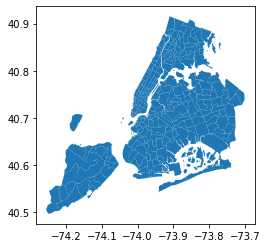

In [4]:
nyc_gdf = gpd.read_file("./shp/taxi_zones.shp")
nyc_gdf = nyc_gdf.to_crs(epsg=4326)
nyc_gdf.plot()

In [5]:
month_request = [3, 6 ,11]
year = 2017
taxi_trips_2017 = get_raw_data(month_request, year)

Preview of data:


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2017-03-01 00:38:16,2017-03-01 00:59:21,1,10.5,1,N,231,42,1,30.5,0.5,0.5,6.00,0.0,0.3,37.80,None,None
1,1,2017-03-01 00:25:01,2017-03-01 00:31:36,1,1.4,1,N,239,262,1,7.5,0.5,0.5,1.75,0.0,0.3,10.55,None,None
2,1,2017-03-01 00:43:48,2017-03-01 00:44:17,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80,None,None



To check: 
 (1) Total number of entries 
 (2) Column types 
 (3) Any null values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29237237 entries, 0 to 9284802
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int64         
 4   trip_distance          float64       
 5   RatecodeID             int64         
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           f

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2017-03-01 00:38:16,2017-03-01 00:59:21,1,10.5,1,N,231,42,1,30.5,0.5,0.5,6.00,0.0,0.3,37.80,None,None
1,1,2017-03-01 00:25:01,2017-03-01 00:31:36,1,1.4,1,N,239,262,1,7.5,0.5,0.5,1.75,0.0,0.3,10.55,None,None
2,1,2017-03-01 00:43:48,2017-03-01 00:44:17,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80,None,None


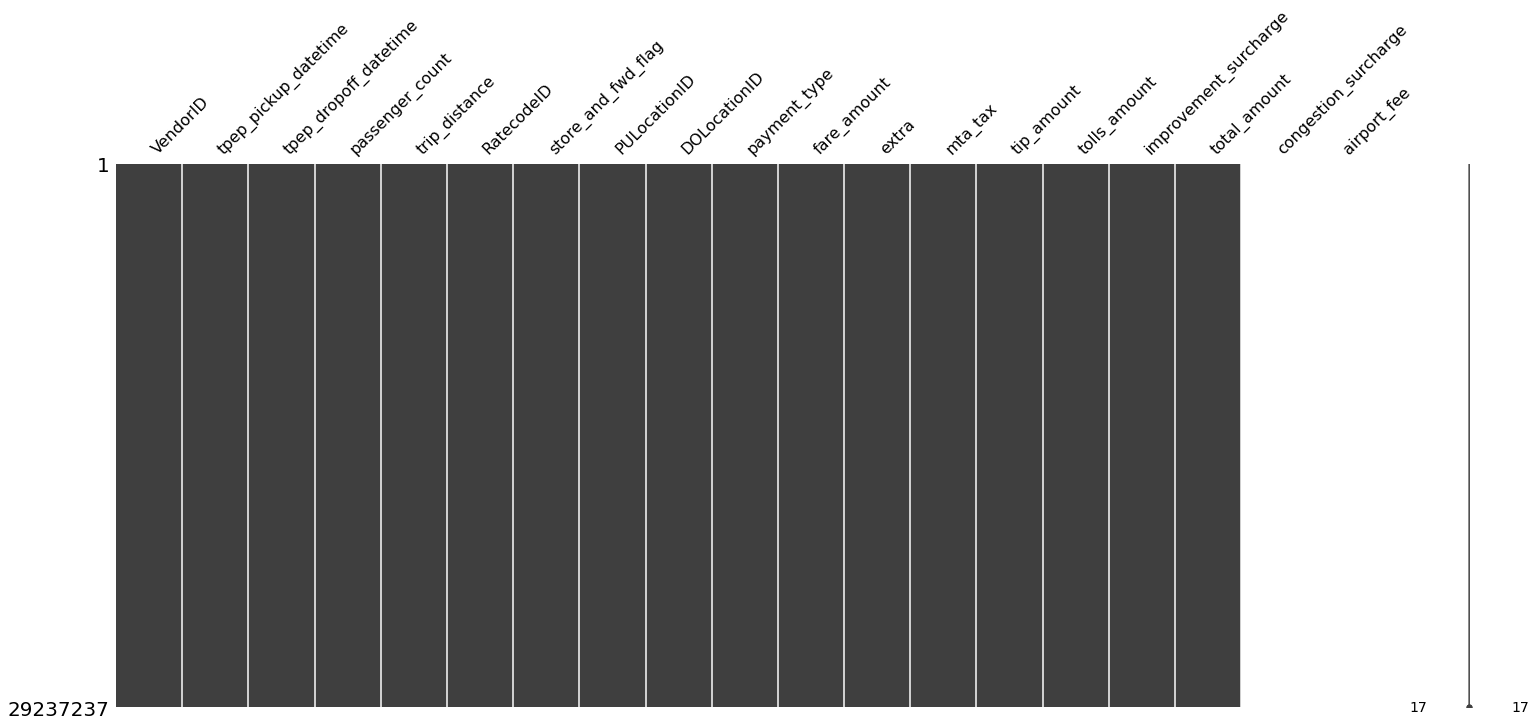


***Number of duplicated entries:  29


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2216359,2,2017-03-07 09:31:18,2017-03-07 17:34:10,1,0.0,1,N,264,264,2,50.2,0.0,0.5,0.0,0.0,0.3,51.0,None,None
2221886,2,2017-03-07 09:31:18,2017-03-07 17:34:10,1,0.0,1,N,264,264,2,50.2,0.0,0.5,0.0,0.0,0.3,51.0,None,None
2227737,2,2017-03-07 09:31:18,2017-03-07 17:34:10,1,0.0,1,N,264,264,2,50.2,0.0,0.5,0.0,0.0,0.3,51.0,None,None
2232881,2,2017-03-07 09:31:18,2017-03-07 17:34:10,1,0.0,1,N,264,264,2,50.2,0.0,0.5,0.0,0.0,0.3,51.0,None,None
2235704,2,2017-03-07 09:31:18,2017-03-07 17:34:10,1,0.0,1,N,264,264,2,50.2,0.0,0.5,0.0,0.0,0.3,51.0,None,None



To check: 
Unique count of non-numeric data

store_and_fwd_flag      2
congestion_surcharge    0
airport_fee             0
dtype: int64
Top 5 unique values of store_and_fwd_flag
  store_and_fwd_flag     Count
0                  N  29112771
1                  Y    124466
 
Top 5 unique values of congestion_surcharge
Empty DataFrame
Columns: [congestion_surcharge, Count]
Index: []
 
Top 5 unique values of airport_fee
Empty DataFrame
Columns: [airport_fee, Count]
Index: []
 

To check: 
Distribution of numeric data


,count,mean,std,min,25%,50%,75%,max
VendorID,29237237.0,1.545916,0.497887,1.00,1.00,2.00,2.00,2.00
passenger_count,29237237.0,1.617837,1.261040,0.00,1.00,1.00,2.00,192.00
trip_distance,29237237.0,2.919382,4.476505,0.00,0.97,1.60,3.01,9496.98
RatecodeID,29237237.0,1.043349,0.509505,1.00,1.00,1.00,1.00,99.00
PULocationID,29237237.0,163.202378,66.614078,1.00,114.00,162.00,233.00,265.00
DOLocationID,29237237.0,161.191045,70.478129,1.00,107.00,162.00,233.00,265.00
payment_type,29237237.0,1.329499,0.490346,1.00,1.00,1.00,2.00,5.00
fare_amount,29237237.0,13.109283,147.279632,-550.00,6.50,9.50,14.50,630461.82
extra,29237237.0,0.333942,0.461572,-53.71,0.00,0.00,0.50,69.80
mta_tax,29237237.0,0.497310,0.070816,-0.50,0.50,0.50,0.50,140.00


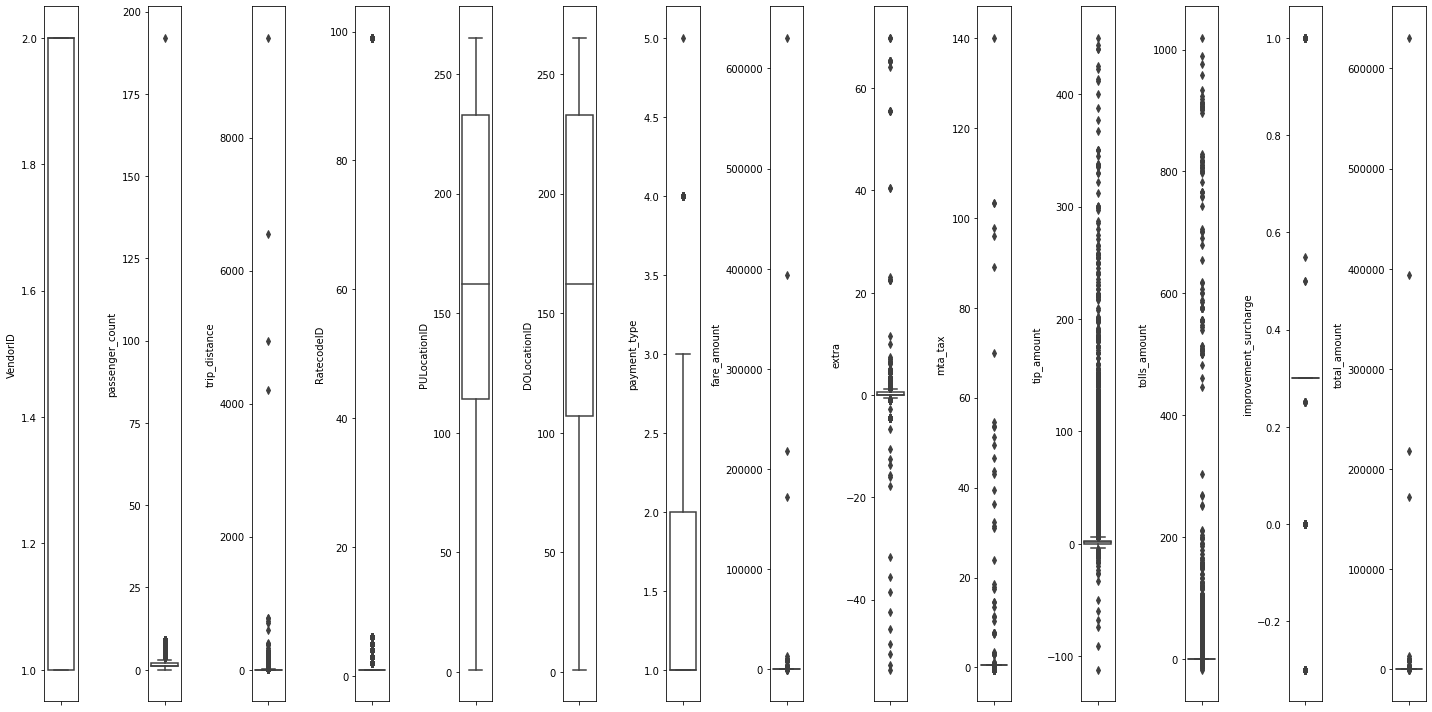


To check pairwise joint distribution of continuous numeric data



KeyboardInterrupt



Error in callback <function flush_figures at 0x000002018157D0D0> (for post_execute):



KeyboardInterrupt



In [22]:
eda(taxi_trips_2017)

Due to taxi_trips_2017 is a large dataset, the pairplot above only shows a subset of the dataset (continuous variables) that allows to check path trend relathionships among the variables. However, it is not possible to check the presence of all the outliers or observations that should be discussed later.
In order to make a detailed analysis, let's see the distribution of continuous numerical variables:

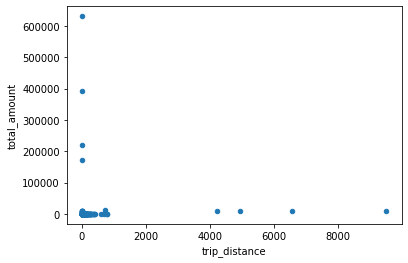

In [23]:
scatterplot(taxi_trips_2017, "trip_distance", "total_amount")

Once the basic eda is done, let's discuss some points... 

- There are observations with data from other years and months.
- **Congestion_surchage** is an empty series which looks weird. One possibility to create a serie can be calculate the average speed of the taxi in order to evaluate if there were traffic jams. 
- **Airport_fee** is always na as well. However, it seems easy to know which pick up zones correspond to LaGuardia and JFK Airports. Let's impute $1.25 in these trips.
- Some **numeric data** presents negative values which can be converted to positive. All of these values are referred to taxes so can't be lower than 0. Let's convert negative to possitive values
- There is a trip with almost 200 passengers which must be a human error. Let's drop this row.
- There are many trips with no **trip_distance**. There are different possibilities here:
    1. Those trips are voided trips and the **Payment_type** attribute must be changed. Besides, if the trip was cancelled, it seems logical that the **Total_amount** variable must be converted to 0. 
    2. The taximeter broke down and the trip was completed but there was no record of distance. In order to impute a distance, two options looks reasonable:
    
        2.1. Calculate the mean of distances for trips with the same origin and destination zones.
        
        2.2. Through the shp file and osmnx library (from openstreetmaps services) i.e. download the road network between two zones and calculate the distance between two points (maybe, the centroids...)
        
- There are 29 duplicated rows that must be dropped from the dataset.
- There is a **rate_code** which is upper than 6. Let's check if a new code can be imputed according to the end zone of the trip
- **MTA_tax** and **Improvement_surcharge** variables must be 0 or 0.5 and 0.3 respectivelly, but there are different values. Let's modify the different values
- Looks weird the distribution of **trip distance** and **total_amount**... There are 4 trips too expensive for its distance and 4 long trips too cheap. It seems reasonable to drop these 8 observations
- RatecodeID max is 99 but it should be an integer between 1 and 6


Therefore, next steps are:

    1. Clean the data according to the points discussed above.
    2. Do further analysis according to the data (the previous analysis can be considered as a generical EDA)

#### Data cleaning <a id="cleaning" ></a>

[Back to contents](#intro)

In [24]:
# Cleaning the data

# Dates
taxi_trips_2017 = taxi_trips_2017.drop(taxi_trips_2017[taxi_trips_2017.tpep_pickup_datetime.dt.month.isin([12, 1])].index)
taxi_trips_2017 = taxi_trips_2017.drop(taxi_trips_2017[taxi_trips_2017.tpep_pickup_datetime.dt.year != 2017].index)

# drop duplicates
taxi_trips_2017 = taxi_trips_2017.drop_duplicates()

# $1.25 for trips from LaGuardia and JFK airports
taxi_trips_2017.loc[taxi_trips_2017["PULocationID"].
                    isin(nyc_gdf[nyc_gdf["zone"].isin(["LaGuardia Airport", "JFK Airport"])].loc[:, "LocationID"].to_list()), "airport_fee"] = 1.25

# negative fares, tips, tolls, and total amount to positive
taxi_trips_2017["fare_amount"] = abs(taxi_trips_2017["fare_amount"])
taxi_trips_2017["tip_amount"] = abs(taxi_trips_2017["tip_amount"])
taxi_trips_2017["tolls_amount"] = abs(taxi_trips_2017["tolls_amount"])
taxi_trips_2017["total_amount"] = abs(taxi_trips_2017["total_amount"])

# drop trips with more than 9 passengers
taxi_trips_2017 = taxi_trips_2017.drop(taxi_trips_2017[taxi_trips_2017.passenger_count > 9].index)

# non-zero values of MTA_tax and Improvement_surcharge to 0.5 and 0.3 respectivelly
taxi_trips_2017.loc[taxi_trips_2017["mta_tax"] != 0, "mta_tax"] = 0.5
taxi_trips_2017.loc[taxi_trips_2017["improvement_surcharge"] != 0, "improvement_surcharge"] = 0.3

# drop super expensive-short and super cheap-long trips
taxi_trips_2017 = taxi_trips_2017.drop(taxi_trips_2017[taxi_trips_2017.trip_distance > 4000].index)
taxi_trips_2017 = taxi_trips_2017.drop(taxi_trips_2017[taxi_trips_2017.total_amount > 100000].index)

# drop ratecode id > 6
taxi_trips_2017 = taxi_trips_2017.drop(taxi_trips_2017[taxi_trips_2017.RatecodeID > 6].index)

Let's explore a bit more... What's happening with trips with no amount and no distance... 

In [25]:
print(f"trips with total amount = 0: {len(taxi_trips_2017[taxi_trips_2017.total_amount==0])}")
print(f"trips with trip distance = 0: {len(taxi_trips_2017[taxi_trips_2017.trip_distance==0])}")
print(f"trips with total amount and trip distance = 0: {len(taxi_trips_2017[(taxi_trips_2017.trip_distance == 0) & (taxi_trips_2017.total_amount == 0)])}")

trips with total amount = 0: 3743
trips with trip distance = 0: 190935
trips with total amount and trip distance = 0: 3220


So, 3259 trips has no distance and no amount which means that were voided by the passengers. Let's impute this in the variable payment_type

The other observations does not make sense... It may are errors so let's drop it

In [26]:
# voided trips
taxi_trips_2017.loc[taxi_trips_2017[(taxi_trips_2017.trip_distance == 0) & (taxi_trips_2017.total_amount == 0)].index,
                                     "payment_type"] = 6

# drop errors
taxi_trips_2017 = taxi_trips_2017.drop(taxi_trips_2017[(taxi_trips_2017.trip_distance == 0) & (taxi_trips_2017.payment_type != 6)].index)
taxi_trips_2017 = taxi_trips_2017.drop(taxi_trips_2017[(taxi_trips_2017.total_amount == 0) & (taxi_trips_2017.payment_type != 6)].index)

Now the dataset looks better, but let's continue exploring

Text(0.5, 1.0, 'avg_speed')

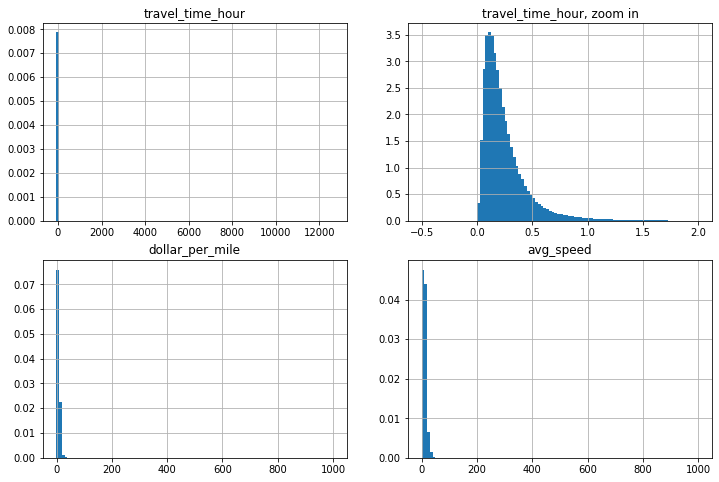

In [27]:
# Let's create some new variables
taxi_trips_2017["travel_time"] = taxi_trips_2017["tpep_dropoff_datetime"] - taxi_trips_2017["tpep_pickup_datetime"]
taxi_trips_2017["travel_time_hour"] = taxi_trips_2017['travel_time'] / np.timedelta64(1, 'h')
taxi_trips_2017["avg_speed"] = taxi_trips_2017["trip_distance"] / taxi_trips_2017["travel_time_hour"]
taxi_trips_2017["dollar_per_mile"] = taxi_trips_2017["total_amount"] / taxi_trips_2017["trip_distance"]

# and plot it to see how are distributed
plt.subplot(2,2,1)
taxi_trips_2017.travel_time_hour.hist(bins=100, figsize=(12,8), density=True)
plt.title('travel_time_hour')
plt.subplot(2,2,2)
taxi_trips_2017.travel_time_hour.hist(bins=100, figsize=(12,8), range=[-0.5, 2], density=True)
plt.title('travel_time_hour, zoom in')
plt.subplot(2,2,3)
taxi_trips_2017.dollar_per_mile.hist(bins=100, figsize=(12,8), range=[-0.5, 1000], density=True)
plt.title('dollar_per_mile')
plt.subplot(2,2,4)
taxi_trips_2017.avg_speed.hist(bins=100, figsize=(12,8), range=[-0.5, 1000], density=True)
plt.title('avg_speed')

- There are super long trips... But for now, lets zoom the distribution around 0
- There are some trips with the same pickup and drop datetime and that is not possible. Let's drop those observation and then, lets have a look to largest travel times...
- It seems like there are super fast taxis is NYC... It is not possible to drive faster than 93 mph (which is approximately 150 km/h)

In [28]:
# drop errors
taxi_trips_2017 = taxi_trips_2017.drop(taxi_trips_2017[taxi_trips_2017.travel_time_hour <= 0].index)
taxi_trips_2017 = taxi_trips_2017.drop(taxi_trips_2017[taxi_trips_2017.travel_time_hour > 200].index)
taxi_trips_2017 = taxi_trips_2017.drop(taxi_trips_2017[taxi_trips_2017.avg_speed >= 93].index)

Let's check if the Ratecode ID makes sense according to the NYC taxi zones...

In [46]:
print(f"Newark LocationID area is: {nyc_gdf[nyc_gdf['zone'].str.contains('Newark')]['LocationID'].item()}")
print(f"There are {len(taxi_trips_2017[(taxi_trips_2017['RatecodeID'] == 3) & ((taxi_trips_2017['PULocationID'] == nyc_gdf[nyc_gdf['zone'].str.contains('Newark')]['LocationID'].item()) | ((taxi_trips_2017['DOLocationID'] == nyc_gdf[nyc_gdf['zone'].str.contains('Newark')]['LocationID'].item())))])} whose Ratecode ID is not Newark (3)")

print(f"Westchester LocationID area is: {nyc_gdf[nyc_gdf['zone'].str.contains('Westchester')]['LocationID'].item()}")
print(f"There are {len(taxi_trips_2017[(taxi_trips_2017['RatecodeID'] == 4) & (((taxi_trips_2017['PULocationID'] == nyc_gdf[nyc_gdf['zone'].str.contains('Westchester')]['LocationID'].item())) | ((taxi_trips_2017['DOLocationID'] == nyc_gdf[nyc_gdf['zone'].str.contains('Westchester')]['LocationID'].item())))])} whose Ratecode ID is not Westchester (4)")

print(f"JFK LocationID area is: {nyc_gdf[nyc_gdf['zone'].str.contains('JFK')]['LocationID'].item()}")
print(f"There are {len(taxi_trips_2017[(taxi_trips_2017['RatecodeID'] == 2) & (((taxi_trips_2017['PULocationID'] == nyc_gdf[nyc_gdf['zone'].str.contains('JFK')]['LocationID'].item())) | ((taxi_trips_2017['DOLocationID'] == nyc_gdf[nyc_gdf['zone'].str.contains('JFK')]['LocationID'].item())))])} whose Ratecode ID is not JFK (2)")

Newark LocationID area is: 1
There are 51268 whose Ratecode ID is not Newark (3)
Westchester LocationID area is: 250
There are 2 whose Ratecode ID is not Westchester (4)
JFK LocationID area is: 132
There are 572420 whose Ratecode ID is not JFK (2)


Ops... It do not seems ok. Let's fix it

In [48]:
taxi_trips_2017.loc[(taxi_trips_2017['RatecodeID'] != 3) & ((taxi_trips_2017['PULocationID'] == 1) | ((taxi_trips_2017['DOLocationID'] == 1))), "RatecodeID"] = 3
taxi_trips_2017.loc[(taxi_trips_2017['RatecodeID'] != 4) & ((taxi_trips_2017['PULocationID'] == 250) | ((taxi_trips_2017['DOLocationID'] == 250))), "RatecodeID"] = 4
taxi_trips_2017.loc[(taxi_trips_2017['RatecodeID'] != 2) & ((taxi_trips_2017['PULocationID'] == 132) | ((taxi_trips_2017['DOLocationID'] == 132))), "RatecodeID"] = 2